<a href="https://colab.research.google.com/github/scline6/ShapeRecognitionAndParameterFitting/blob/master/ShapeRecognitionAndParameterFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OVERVIEW
*   I took on the challenge of self-studying deep learning, and this 
is my first experience. Tensorflow on Colab has been smooth as can be, so that was a pleasant surprise!

*   I started out with the MNIST hand-written digits classification tutorial, and had an idea.  What if you could convert 2D or 3D geometric models in triangle mesh, image, or volumetric format into Constructive Solid Geometry (CSG)?  Typical CSG models are made from polygons, ellipses, extrusions, polyhedra, cylinders, ellipsoids, boolean operations, hulls, and Minkowski sums.  If you generated a training dataset consisting of CSG models with their correct labels (per point or pixel for segmentation), maybe you could train a deep learning model to recognize the constituents of the CSG model.  Then you might be able to send in models that were not originally CSG-generated and the deep learning model would reconstruct them as CSG.  It is also possible that the nested structure of boolean operations and hulls might prevent feedforward nets from being able to reverse engineer CSG models.  Recurrent nets might be required.

*   To limit the scope to a reasonable start, I wanted to see if deep learning can classify 2D images that each contains a single shape, either a rectangle and ellipse and estimate the original parameters that were used to generate the rectangles and ellipses.  Later, I would like to move on to multiple shapes per image and image segmentation.

*   I wrote a simple C++/Qt program that generates rectangles (SHAPE=0) and ellipses (SHAPE=1).  The training set has 50000 images, the test set has 15000 images and the validation set has 5000 images.  The images are 50x50 pixels.  When scaled to the 0-1 range, each pixel has width of 0.02.

*   Classification went well with over 99.9% accuracy, and the only issues were very small shapes or rectangles with pixelated corners that are hard even for a human to distinguish from an ellipse.

*   The continuous parameters are CENTER_X, CENTER_Y, THETA, MAJOR_DIAM, MINOR_DIAM.  Currently, CENTER_X and CENTER_Y fit very closely to the test data.  MAJOR_DIAM and MINOR_DIAM have a decent fit, but could probably be improved.  The THETA parameter did not fit well because it belongs to the circular group where 0 degrees is the same as 360 degrees.  Replacing THETA with cos(THETA) and sin(THETA) should work better, but I will leave that as a future exercise.

STEP #1: AUTOMATIC GENERATION OF DATASET
1. Copy the C++/Qt code to your local machine, then compile and run it code to generate the dataset.  There will be three output folders (shapes-train-images, shapes-test-images & shapes-val-images) and three output files (shapes-train-labels.csv, shapes-test-labels.csv & shapes-val-labels.csv).
2. Zip the output folders into .tar.gz files (shapes-train-images.tar.gz, shapes-test-images.tar.gz & shapes-val-images.tar.gz).
3. Upload the three .tar.gz files and three .csv *files* to Google Drive.

In [ ]:
"""
//main.cpp

#include <QCoreApplication>
#include <QImage>
#include <QPixmap>
#include <QPainter>
#include <QFile>
#include <QFileInfo>
#include <QDir>
#include <QTextStream>
#include <array>
#include <cmath>
#include <algorithm>
#include <stdlib.h>
#include <iostream>
#include <QDebug>


// Generate images of this size
const double X_SIZE = 50.0;
const double Y_SIZE = 50.0;
const double MAX_SIZE = (X_SIZE > Y_SIZE ? X_SIZE : Y_SIZE);    // Used for making sure all of the shape is in the image


// Array or CSV column index of each attribute
const std::size_t SHAPE      = 0;
const std::size_t CENTER_X   = 1;
const std::size_t CENTER_Y   = 2;
const std::size_t THETA      = 3;
const std::size_t MAJOR_DIAM = 4;
const std::size_t MINOR_DIAM = 5;
const std::size_t TOTAL_NUM_ATTRIBUTES = 6;


enum ShapeCategory
{
    RECTANGLE = 0,
    ELLIPSE   = 1,
};


enum FillType
{
    SOLID   = 0,
    OUTLINE = 1,
};


int generateShape(QFile& csvFile, QDir& imageDir,
                  const int& index, const ShapeCategory& shape,
                  const double& x, const double& y, const double& theta,
                  const double& major, const double& minor,
                  const FillType& fillType, const int& lineWidth)
{
    // Use QPainter and QImage to make rectangle and ellipse images
    QImage image(X_SIZE, Y_SIZE, QImage::Format_Mono);
    image.fill(0);
    QPainter painter;
    painter.begin(&image);
    if (fillType == FillType::SOLID)
    {
        painter.setBrush( QBrush(Qt::white, Qt::BrushStyle::SolidPattern) );
        painter.setPen( QPen(Qt::white, 0, Qt::NoPen) );
    }
    else if (fillType == FillType::OUTLINE) {
        painter.setBrush( QBrush(Qt::white, Qt::BrushStyle::NoBrush) );
        painter.setPen( QPen(Qt::white, lineWidth, Qt::SolidLine) );
    }
    painter.translate( QPointF(x, y) );
    painter.rotate(theta);
    if (shape == ShapeCategory::RECTANGLE)
    {
        painter.drawRect( QRectF(-0.5*major, -0.5*minor, major, minor) );
    }
    else if (shape == ShapeCategory::ELLIPSE)
    {
        painter.drawEllipse( QRectF(-0.5*major, -0.5*minor, major, minor) );
    }
    painter.end();

    // Save the image file into the image path
    const QString fileName = imageDir.filePath("image" + QString::number(index) + ".png");
    int result = image.save(fileName);

    // Write out one-hot categories and shape parameters to a row in the csv file
    QTextStream csvStream(&csvFile);
    std::array<double,TOTAL_NUM_ATTRIBUTES> attribute;
    attribute[SHAPE]      = double(int(shape));
    attribute[CENTER_X]   = x;
    attribute[CENTER_Y]   = y;
    attribute[THETA]      = theta;
    attribute[MAJOR_DIAM] = major;
    attribute[MINOR_DIAM] = minor;
    for (const double& a : attribute) csvStream << a <<",";
    csvStream << "\n";

    return 0;
}


int generateRandomShapes(const QString& pathName, const QString& imageFolderName, const QString& csvFileName,
                         const std::size_t& seed, const std::size_t& n, const FillType& fillType)
{
    // Open the csv file and make the image directory so they is ready for appending a new lines and images for each generated shape
    QDir imageDir( QDir::cleanPath(pathName + QDir::separator() + imageFolderName) );
    if (!imageDir.exists()) QDir().mkpath(imageDir.absolutePath());
    QFile csvFile( QDir::cleanPath(pathName + QDir::separator() + csvFileName) );
    if (csvFile.open(QIODevice::Append)) {
        std::cerr << "CSV Output File opened successfully\n";
    }
    else {
        std::cerr << "CSV Output File could not be opened in append mode\n";
        std::cerr << csvFile.errorString().toStdString();
        return -1;
    }

    // Generate random shapes and parameters, then produce images with those shapes
    srand(seed);
    std::size_t index = 0;
    while (index < n)
    {
        const ShapeCategory shape = ShapeCategory(rand() % 2);
        const double x = X_SIZE * (0.5 + double(rand())) / double(RAND_MAX);
        const double y = Y_SIZE * (0.5 + double(rand())) / double(RAND_MAX);
        const double theta = 360.0 * (0.5 + double(rand())) / double(RAND_MAX) - 180.0;
        const double major = X_SIZE * (0.5 + double(rand())) / double(RAND_MAX);
        const double minor = Y_SIZE * (0.5 + double(rand())) / double(RAND_MAX);
        if (major < minor) continue;    // Make sure the major axis is bigger than the minor axis since theta is defined as X to major
        if (minor < 6.5) continue;      // Make sure the minor axis is at least 7 pixels
        const std::array<double,4> distToEdges = {x, y, X_SIZE-x, Y_SIZE-y};
        const double minDistToEdge = *std::min_element(distToEdges.begin(), distToEdges.end());
        const int lineWidth = (fillType == FillType::SOLID ? 0 : 1 + rand() % 5);     // pick 1, 2, 3, 4, or 5
        if (0.5 * sqrt(major * major + minor * minor) + 0.5 * double(lineWidth) + 1.0 >= minDistToEdge) continue;    // Make sure the entire shape is in the image - later bounding boxes will ensure this
        const int result = generateShape(csvFile, imageDir, index, shape, x, y, theta, major, minor, fillType, lineWidth);
        if (result < 0) continue;
        index++;
    }

    csvFile.close();
    return 0;
}


int main()
{
    generateRandomShapes("/home/shane/Documents/TensorFlow/ShapeGenerator/Output", "shapes-train-images", "shapes-train-labels.csv", 1, 50000, FillType::SOLID);
    generateRandomShapes("/home/shane/Documents/TensorFlow/ShapeGenerator/Output", "shapes-test-images", "shapes-test-labels.csv", 2, 15000, FillType::SOLID);
    generateRandomShapes("/home/shane/Documents/TensorFlow/ShapeGenerator/Output", "shapes-val-images", "shapes-val-labels.csv", 3, 5000, FillType::SOLID);
    return 0;
}
"""


STEP #2: LOAD DATASET - PART A
> Run the following python script to load the dataset from your Google Drive.

> After reading in, the dataset will be stored in a ShapeData class object name "data".  The rest of this session will reference the "data" object.  The important members of the ShapeData class are x_train, y_train, x_test, y_test, x_val, and y_val.  There are auxiliary members such as img_shape and img_size_flat, as well as auxiliary functions such as is_categorical(ov_index).  These will show up subsequent code blocks.



In [ ]:
# Import matplotlib for plotting (inline, not a separate window)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import math and matrix libraries
import math
import numpy as np
from sklearn.metrics import confusion_matrix

# Import tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.models import Model
print("Tensorflow Version: ",tf.__version__)    # Double-check the Tensorflow version

# Import os and zip utility libraries
import os
import tarfile
import ntpath
from google.colab import files, drive

# Filenames for the data-set
filename_x_train = "shapes-train-images.tar.gz"
filename_y_train = "shapes-train-labels.csv"
filename_x_test  = "shapes-test-images.tar.gz"
filename_y_test  = "shapes-test-labels.csv"
filename_x_val   = "shapes-val-images.tar.gz"
filename_y_val   = "shapes-val-labels.csv"

# Ouput variable encoded as indices (same as data columns in the csv file)
SHAPE      = 0
CENTER_X   = 1
CENTER_Y   = 2
THETA      = 3
MAJOR_DIAM = 4
MINOR_DIAM = 5
TOTAL_NUM_OUTPUTS = 6

# Shapes encodes as integers
RECTANGLE = 0
ELLIPSE   = 1
TOTAL_NUM_SHAPE_CLASSES = 2

# Identify which variables are categorical
def is_categorical(ov_index):    
        return (ov_index == SHAPE)

def num_classes(ov_index):
    if ov_index == SHAPE:
        return TOTAL_NUM_SHAPE_CLASSES
    else:
        return 0

# Convert output variable index to variable name string
def index_to_variable_name(ov_index):    
    if ov_index == SHAPE:
        return "SHAPE"
    elif ov_index == CENTER_X:
        return "CENTER_X"
    elif ov_index == CENTER_Y:
        return "CENTER_Y"
    elif ov_index == THETA:
        return "THETA"
    elif ov_index == MAJOR_DIAM:
        return "MAJOR_DIAM"
    elif ov_index == MINOR_DIAM:
        return "MINOR_DIAM"

# Convert shape class integer to shape class name
def int_to_shape(i, short = False):
    if short:
        if i == 0:
            return "Rec"
        elif i == 1:
            return "Ell"
    else:
        if i == 0:
            return "RECTANGLE"
        elif i == 1:
            return "ELLIPSE"
 
# Convert one-hot encoding to class
def onehot_to_class(y):
    return np.argmax(y,axis=1)


# Python class to hold the entire dataset (x images & y csv table + train, test & val)
class ShapeData:

    def load_x_images(self, targzfilename):
        targzfilepath = os.path.join(self.data_dir, targzfilename)
        tar = tarfile.open(targzfilepath, "r:gz")
        png_members = []
        for member in tar.getmembers():
            if member.name.endswith(".png"):
                png_members += [member]     #make sure the file really is a png file
        self.num_images = len(png_members)
        image = tar.extractfile(png_members[0])    #use the first image to dynamically grab the image size
        img = mpimg.imread(image)
        self.img_shape = (img.shape[0], img.shape[1], 1)
        self.img_size_flat = self.img_shape[0] * self.img_shape[1]
        self.img_size_max = max(self.img_shape[0], self.img_shape[1])
        x = np.zeros( (self.num_images, self.img_size_flat), dtype=float)
        for member in png_members:
            index = int(ntpath.basename(member.name).replace("image","").replace(".png",""))
            image = tar.extractfile(member)
            img = mpimg.imread(image)
            img_mono = np.amax(img[:,:,0:3], axis=2)    #take the max of rbg, but chop off alpha first with 0:3
            x[index,:] = img_mono.flatten()
        tar.close()
        return x

    def load_y_labels(self, csvfilename):
        fin = open(csvfilename, "r")
        lines = fin.readlines()
        fin.close()
        num_images = len(lines)
        y = TOTAL_NUM_OUTPUTS * [None]
        for ov_index in range(0, TOTAL_NUM_OUTPUTS):
            if is_categorical(ov_index):
                y[ov_index] = np.zeros( (num_images, num_classes(ov_index)) )
            else:
                y[ov_index] = np.zeros( (num_images, 1) )
        for i in range(num_images):
            entries = lines[i].split(",")
            shape_int = int(float(entries[SHAPE]) + 0.01)
            y[SHAPE][i,0]    = 1.0 if shape_int == RECTANGLE else 0.0                   #One-hot encoding for rectangle
            y[SHAPE][i,1]    = 1.0 if shape_int == ELLIPSE   else 0.0                   #One-hot encoding for ellipse
            y[CENTER_X][i]   = float(entries[CENTER_X]) / float(self.img_size_max)      #Position of shape center x-coordinate
            y[CENTER_Y][i]   = float(entries[CENTER_Y]) / float(self.img_size_max)      #Position of shape center y-coordinate
            theta = float(entries[THETA])
            if theta < 0.0:
                theta = theta + 180.0    #make sure theta is in the 0-180 range
            y[THETA][i]      = theta / 180.0                                            #Rotation Angle
            y[MAJOR_DIAM][i] = float(entries[MAJOR_DIAM]) / float(self.img_size_max)    #Normalized major diameter
            y[MINOR_DIAM][i] = float(entries[MINOR_DIAM]) / float(self.img_size_max)    #Normalized minor diameter
        return y

    def __init__(self, data_dir):
        self.data_dir  = data_dir
        self.x_train   = self.load_x_images(filename_x_train) / 255.0
        self.y_train   = self.load_y_labels(filename_y_train)
        self.num_train = self.x_train.shape[0]
        self.x_test    = self.load_x_images(filename_x_test) / 255.0
        self.y_test    = self.load_y_labels(filename_y_test)
        self.num_test  = self.x_test.shape[0]
        self.x_val     = self.load_x_images(filename_x_test) / 255.0
        self.y_val     = self.load_y_labels(filename_y_test)
        self.num_val   = self.x_val.shape[0]
       
    def random_batch(self, batch_size):
        indices = np.random.randint(low=0, high=self.num_train, size=batch_size) 
        return self.x_train[indices], self.y_train[indices]

drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/Shapes_Dataset1")
data = ShapeData(".")

Tensorflow Version:  2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


STEP #2: DATASET LOADING - PART B
> Plot a few images to make sure the data is correct.

> It looks like the SHAPE labels came in correct.  Maybe later I will add plots for the continuous variables (CENTER_X, CENTER_Y, THETA, MAJOR_DIAM, and MINOR_DIAM) as well.




#Rectangles, #Ellipses=  [24860. 25140.]


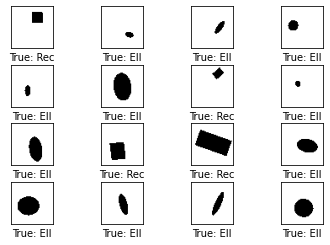

In [ ]:
def plot_images(M, N, img_shape, images, class_true, class_pred=None):
    assert len(images) == len(class_true)
    fig, axes = plt.subplots(M, N)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= min(M * N, len(images)):
            break
        ax.imshow(images[i].reshape(img_shape[0:2]), cmap='binary')
        if class_pred is None:
            xlabel = "True: {0}".format(int_to_shape(class_true[i], True))
        else:
            xlabel = "True: {0}, Pred: {1}".format(int_to_shape(class_true[i], True), int_to_shape(class_pred[i], True))
        ax.set_xlabel(xlabel)
    plt.show()

print("#Rectangles, #Ellipses= ", np.sum(data.y_train[SHAPE], axis=0))
plot_images(4, 4, data.img_shape, images=data.x_test, class_true=onehot_to_class(data.y_test[SHAPE]) )

STEP #3: MODEL DEFINITION
> Build the model layers using Keras functional API in Tensorflow2.  The functional API allows sharing the convolutional layers that extract feature descriptors from the image while at the same time splitting out the last few dense layers into parallel pipelines that predict the six output parameters (categorical SHAPE and continuous CENTER_X, CENTER_Y, THETA, MAJOR_DIAM & MINOR_DIAM).



In [ ]:
# Create an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape=(data.img_size_flat,))

# Variable used for building the Neural Network.
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(data.img_shape)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# Split into several parallel layers for final classification (SHAPE) and regression (CENTER_X, MAJOR_DIAM, etc.)
parallel = []
for i in range(TOTAL_NUM_OUTPUTS):
    if is_categorical(i):
        parallel += [Dense(128, activation='relu')(net)]              # 1st fully-connected / dense layer with ReLU-activation.
        parallel[-1] = tf.keras.layers.Dropout(0.5)(parallel[-1])     # Dropout layer to avoid overfitting
        parallel[-1] = Dense(num_classes(i), activation='softmax', name=index_to_variable_name(i))(parallel[-1])
    else:
        parallel += [Dense(128, activation='relu')(net)]              # 1st fully-connected / dense layer with ReLU-activation.
        parallel[-1] = tf.keras.layers.Dropout(0.5)(parallel[-1])     # Dropout layer to avoid overfitting
        #parallel[-1] = Dense(128, activation='relu')(parallel[-1])    # 2nd fully-connected / dense layer with ReLU-activation.
        #parallel[-1] = tf.keras.layers.Dropout(0.7)(parallel[-1])     # Dropout layer to avoid overfitting
        parallel[-1] = Dense(1, activation='linear', name=index_to_variable_name(i))(parallel[-1])
net = parallel

outputs = net

model = Model(inputs=inputs, outputs=outputs)

STEP #4: TRAINING
> Compile the model, fit it to the training data, and evaluate it on test data.



In [ ]:
########## Settings that you can change ##########
optimizer_type = "ADAM"  #"ADAM" or "RMSPROP"
learning_rate  = 0.001
num_epochs     = 15
batch_size     = 128
##################################################

from tensorflow.keras.optimizers import Adam, RMSprop

optimizer = None
if optimizer_type == "ADAM":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer_type == "RMSPROP":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

losses = []
loss_weights = []
metrics = [tf.keras.metrics.MeanAbsoluteError()]
for i in range(0, TOTAL_NUM_OUTPUTS):
    if is_categorical(i):
        losses += [tf.keras.losses.CategoricalCrossentropy()]
        loss_weights += [1.0]
    else:
        losses += [tf.keras.losses.MeanAbsoluteError()]
        loss_weights += [1.0]

model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=metrics)

model.fit(x=data.x_train, y=data.y_train, epochs=num_epochs, batch_size=batch_size)

result = model.evaluate(x=data.x_test, y=data.y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)

Epoch 1/15
391/391 [==============================] - 5s 12ms/step - loss: 0.8361 - SHAPE_loss: 0.3770 - CENTER_X_loss: 0.0721 - CENTER_Y_loss: 0.0708 - THETA_loss: 0.1846 - MAJOR_DIAM_loss: 0.0815 - MINOR_DIAM_loss: 0.0501 - SHAPE_mean_absolute_error: 0.2727 - CENTER_X_mean_absolute_error: 0.0721 - CENTER_Y_mean_absolute_error: 0.0708 - THETA_mean_absolute_error: 0.1846 - MAJOR_DIAM_mean_absolute_error: 0.0815 - MINOR_DIAM_mean_absolute_error: 0.0501
Epoch 2/15
391/391 [==============================] - 5s 12ms/step - loss: 0.3300 - SHAPE_loss: 0.0330 - CENTER_X_loss: 0.0379 - CENTER_Y_loss: 0.0387 - THETA_loss: 0.1431 - MAJOR_DIAM_loss: 0.0491 - MINOR_DIAM_loss: 0.0282 - SHAPE_mean_absolute_error: 0.0239 - CENTER_X_mean_absolute_error: 0.0379 - CENTER_Y_mean_absolute_error: 0.0387 - THETA_mean_absolute_error: 0.1431 - MAJOR_DIAM_mean_absolute_error: 0.0491 - MINOR_DIAM_mean_absolute_error: 0.0282
Epoch 3/15
391/391 [==============================] - 5s 12ms/step - loss: 0.2543 - SHAP

STEP #5: DIAGNOSTICS - PART A
> Print out the model predictions for the first 20 or 30 images and see if they look good.

> It is good to print each parameter error with sign (+ or -).  Since the model is fit by minimizing mean absolute error loss, which is similar to median, we would like to see a similar number of positive errors and negative errors.  With just the first 20 image predictions printed, it looks like positive and negative errors are fairly balanced for all five continuous parameters (CENTER_X, CENTER_Y, THETA, MAJOR_DIAM, and MINOR_DIAM).  So it passes the quick visual check. 





In [ ]:
FIRST_HOW_MANY = 20
y_pred = model.predict(x=data.x_test)
y_shape_class_pred = onehot_to_class(y_pred[SHAPE])
y_shape_class_true = onehot_to_class(data.y_test[SHAPE])
print(" i |  SHAPE  |       CENTER_X       |       CENTER_Y       |        THETA         |      MAJOR_DIAM      |      MINOR_DIAM     ")
print(" i | Pre Tru |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff")
print("-------------------------------------------------------------------------------------------------------------------------------")
for i in range(0, FIRST_HOW_MANY):
    print("{:2d} | {} {} | {:5.3f}, {:5.3f}, {:+5.3f} | {:5.3f}, {:5.3f}, {:+5.3f} | {:5.3f}, {:5.3f}, {:+5.3f} | {:5.3f}, {:5.3f}, {:+5.3f} | {:5.3f}, {:5.3f}, {:+5.3f}".format( 
          i, int_to_shape(y_shape_class_pred[i],True), int_to_shape(y_shape_class_true[i],True), 
          y_pred[CENTER_X][i,0]  , data.y_test[CENTER_X][i,0]  , y_pred[CENTER_X][i,0]  -data.y_test[CENTER_X][i,0]  ,
          y_pred[CENTER_Y][i,0]  , data.y_test[CENTER_Y][i,0]  , y_pred[CENTER_Y][i,0]  -data.y_test[CENTER_Y][i,0]  , 
          y_pred[THETA][i,0]     , data.y_test[THETA][i,0]     , y_pred[THETA][i,0]     -data.y_test[THETA][i,0]     ,
          y_pred[MAJOR_DIAM][i,0], data.y_test[MAJOR_DIAM][i,0], y_pred[MAJOR_DIAM][i,0]-data.y_test[MAJOR_DIAM][i,0],
          y_pred[MINOR_DIAM][i,0], data.y_test[MINOR_DIAM][i,0], y_pred[MINOR_DIAM][i,0]-data.y_test[MINOR_DIAM][i,0],
    ))

 i |  SHAPE  |       CENTER_X       |       CENTER_Y       |        THETA         |      MAJOR_DIAM      |      MINOR_DIAM     
 i | Pre Tru |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff |  Pred   True    Diff
-------------------------------------------------------------------------------------------------------------------------------
 0 | Rec Rec | 0.615, 0.625, -0.010 | 0.276, 0.269, +0.006 | 0.398, 0.486, -0.089 | 0.310, 0.268, +0.042 | 0.243, 0.260, -0.017
 1 | Ell Ell | 0.688, 0.677, +0.011 | 0.674, 0.681, -0.007 | 0.226, 0.099, +0.127 | 0.240, 0.208, +0.032 | 0.146, 0.133, +0.012
 2 | Ell Ell | 0.678, 0.685, -0.007 | 0.512, 0.509, +0.003 | 0.668, 0.697, -0.029 | 0.342, 0.361, -0.019 | 0.153, 0.131, +0.021
 3 | Ell Ell | 0.313, 0.291, +0.022 | 0.460, 0.463, -0.003 | 0.566, 0.743, -0.177 | 0.257, 0.249, +0.008 | 0.226, 0.246, -0.020
 4 | Ell Ell | 0.387, 0.399, -0.012 | 0.614, 0.617, -0.002 | 0.498, 0.507, -0.009 | 0.244, 0.257, -0.013

STEP #5: DIAGNOSTICS - PART B
> Use the fitted model to classify the first few images and see if the predictions are correct or not.



#Rectangles, #Ellipses=  7458 7542


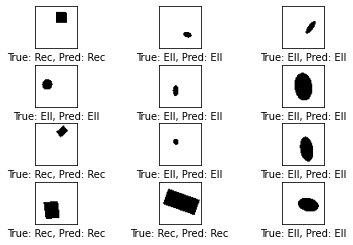

In [ ]:
y_shape_class_true = onehot_to_class(data.y_test[SHAPE])
y_pred = model.predict(x=data.x_test)
y_shape_class_pred = onehot_to_class(y_pred[SHAPE])
print("#Rectangles, #Ellipses= ", sum(y_shape_class_pred==RECTANGLE), sum(y_shape_class_pred==ELLIPSE))
plot_images(4, 3, data.img_shape, images=data.x_test, class_true=y_shape_class_true, class_pred=y_shape_class_pred)

STEP #5: DIAGNOSTICS - PART C
> Examine the first few classification errors.

> The first thing to note is, there are only 9 misclassifications out of 15000.  So that is 99.94% accuracy, which is very high.

> The C++ shape generator requires MINOR_DIAM > 7 pixels.  This was added because small dots would be hard to classify as either rectangle or ellipse.  Even so, I expect the harder cases to be 7-10 pixel by 7-10 pixels.  That is true from 6 out of the 9 misclassifications below.

> However, there is another problem too.  Three out of the 9 misclassifications are sizeable shapes.  Their CENTER_X, CENTER_Y, THETA, MAJOR_DIAM, and MINOR_DIAM parameters are all real number (floats).  When QImage pixelates them, it seems to chop the corners off for particular parameter combinations.  So the rectangles end up with rounded corners and are easy to misclassify as ellipses. 







#Incorrect=  10


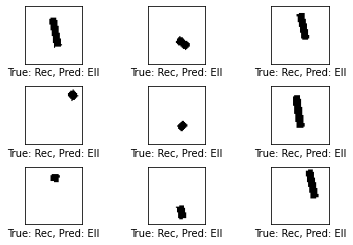

In [ ]:
def plot_example_errors(M, N, img_shape, y_pred, ov_index):
    class_pred = onehot_to_class(y_pred[ov_index])
    incorrect = (class_pred != onehot_to_class(data.y_test[ov_index]))          # Boolean array whether the predicted class is incorrect.
    images_incorrect = data.x_test[incorrect]                                # Get the images from the test-set that have been incorrectly classified.
    print("#Incorrect= ", len(images_incorrect))                                       # Get the predicted classes for those images.
    clas_prec_incorrect  = class_pred[incorrect]                             # Get the true classes for those images.
    class_true_incorrect = onehot_to_class(data.y_test[ov_index][incorrect])    # Get the true classes for those images.
    plot_images(M, N, img_shape=img_shape, images=images_incorrect, class_true=class_true_incorrect, class_pred=clas_prec_incorrect)

y_pred = model.predict(x=data.x_test)
plot_example_errors(3, 3, data.img_shape, y_pred, SHAPE)

STEP #5: DIAGNOSTICS - PART D
> Examine the confusion matrix to see what kinds of classification errors are common.

> For this particular fit, all 9 misclassifications are true rectangles that were erroneously classified as ellipses.  I have noticed that changing the model, number of epochs, or learning rate can cause all misclassifications to be of the other type.  I am not experienced with deep learning to know this for sure.  But it seems that for classification models with very high accuracy, it might be hard to make the predictions unbiased.



[[7458   10]
 [   0 7532]]


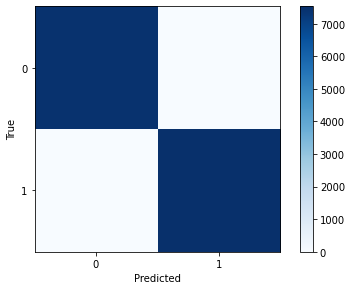

In [ ]:
def print_confusion_matrix(ov_index):
    class_true = onehot_to_class(data.y_test[ov_index])
    y_pred = model.predict(x=data.x_test)
    class_pred = onehot_to_class(y_pred[ov_index])
    cm = confusion_matrix(y_true=class_true, y_pred=class_pred)    # Get the confusion matrix using sklearn.
    print(cm)                                                      # Print the confusion matrix as text.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)     # Plot the confusion matrix as an image.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes(ov_index))
    plt.xticks(tick_marks, range(num_classes(ov_index)))
    plt.yticks(tick_marks, range(num_classes(ov_index)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(SHAPE)

STEP #5: DIAGNOSTICS - PART E
> For all the continuous (non-categorical) parameters, plot the true parameters on the x-axis and predicted parameters on the y-axis.  

> The current results show that CENTER_X and CENTER_Y are fit to sub-pixel accuracy, which is good.  The mean absolute error is about 0.007, which is one-third the pixel size of 0.02.

> MAJOR_DIAM and MINOR_DIAM have mean absolute error around 0.02 or 1 pixel accuracy.  It should be possible to build a better network and achieve a closer fit. As I learn more about neural network architecture, I will come back and give this a try.

> The THETA parameter is not fitting well at all.  This warrants further investigation in PART F below.





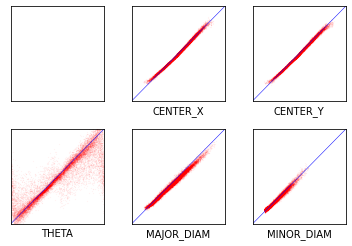

In [ ]:
def plot_parameter_fitting(M, N, y_true, y_pred, labeling=[], colorPoint='r', s=0.0002, colorLine='b', linewidth=0.5):
    fig, axes = plt.subplots(M, N)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= M * N:
            break
        if labeling == [] and is_categorical(i):
            continue
        elif labeling != [] and i >= len(y_true):
            break
        ax.scatter(y_true[i], y_pred[i], color=colorPoint, s=s)
        x = np.linspace(0, 1, 2)
        ax.plot(x, x, color=colorLine, linewidth=linewidth)
        if labeling == []:
            ax.set_xlabel(index_to_variable_name(i))
        else:
            ax.set_xlabel(str(labeling[i]))
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    plt.show()

y_pred = model.predict(x=data.x_test)
plot_parameter_fitting(2, 3, data.y_test, y_pred)


STEP #5: DIAGNOSTICS - PART F
> Plot theta curve omitting cases where MAJOR_DIAM - MINOR_DIAM < THRESHOLD.  This will help to see if the poor fit for THETA is caused by ellipses that are nearly circular.  In that case THETA would be hard for the model to predict.

> No matter what THRESHOLD is chosen, the result is the similar.  Near THETA=0 and THETA=180, there is a lot of error.  In the middle region (30<THETA<150), there is more error with THRESHOLD=0.01 than THRESHOLD = 0.08.  So nearly circular ellipses do present a minor problem.  But there is clearly a more insidious problem at work.

> The more insidious problem is the nature of THETA.  It belongs to circle group C1 where 0 degrees and 180 degrees are really equal!  This makes it difficult for the model, which is fitted using mean absolute error loss, to predict good estimates near 0 and 180 degrees.  A note about THETA: in general, THETA ranges from -180 to +180 degrees.  In this case, rectangles and ellipses have radial symmetry with n=2.  At read-in time, 180 was added to all negative angles to make them positive.

> If true THETA were 1 degree and the predicted THETA was 179 degrees, the error would look large, but it would be acceptable.  However, the plot shows that when true THETA is 1 degree, the predicted THETA values are all over the place.  This is poor model performance.  

> I would like to find a strategy for working with variables on circular groups.  There are two possibilities.
1.   Find a deep learning architecture that respects variables with domains over the circular group.
2.   Find an input transform.  For example, one could replace one variable THETA with two variables cos(THETA) and sin(THETA).  This one seems like the more expedient solution.











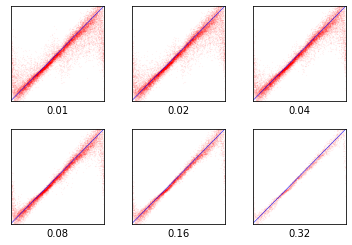

In [ ]:
y_pred = model.predict(x=data.x_test)
y_test_some = []
y_pred_some = []
threshold_levels = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
for threshold in threshold_levels:
    indices = data.y_test[MAJOR_DIAM] - data.y_test[MINOR_DIAM] > threshold
    y_test_some += [data.y_test[THETA][indices]]
    y_pred_some += [y_pred[THETA][indices]]
plot_parameter_fitting(2, 3, y_test_some, y_pred_some, threshold_levels)